In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import networkx as nx

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-adjust width
pd.set_option('display.colheader_justify', 'left')  # Align headers properly
pd.set_option('display.max_colwidth', None)  # Don't truncate column values

/Users/emmalim/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Initial Feature Selection and Engineering

In [53]:
merged_df = pd.read_csv('/Users/emmalim/Desktop/DSA4263/final_data.csv')
print("Before Label Mapping: ")
print(merged_df["Label"].value_counts())
print("---------------------------------------")
merged_df['Label'] = merged_df['Label'].apply(lambda x: 0 if x in ['Benign'] else 1)
print("After Label Mapping: ")
merged_df["Label"].value_counts()

Before Label Mapping: 
Label
Benign                    1343290
DDoS attacks-LOIC-HTTP     575394
DoS Hulk                   231073
DDoS                       128027
DoS GoldenEye               10293
DoS slowloris                5796
DoS Slowhttptest             5499
Bot                          1966
Heartbleed                     11
Name: count, dtype: int64
---------------------------------------
After Label Mapping: 


Label
0    1343290
1     958059
Name: count, dtype: int64

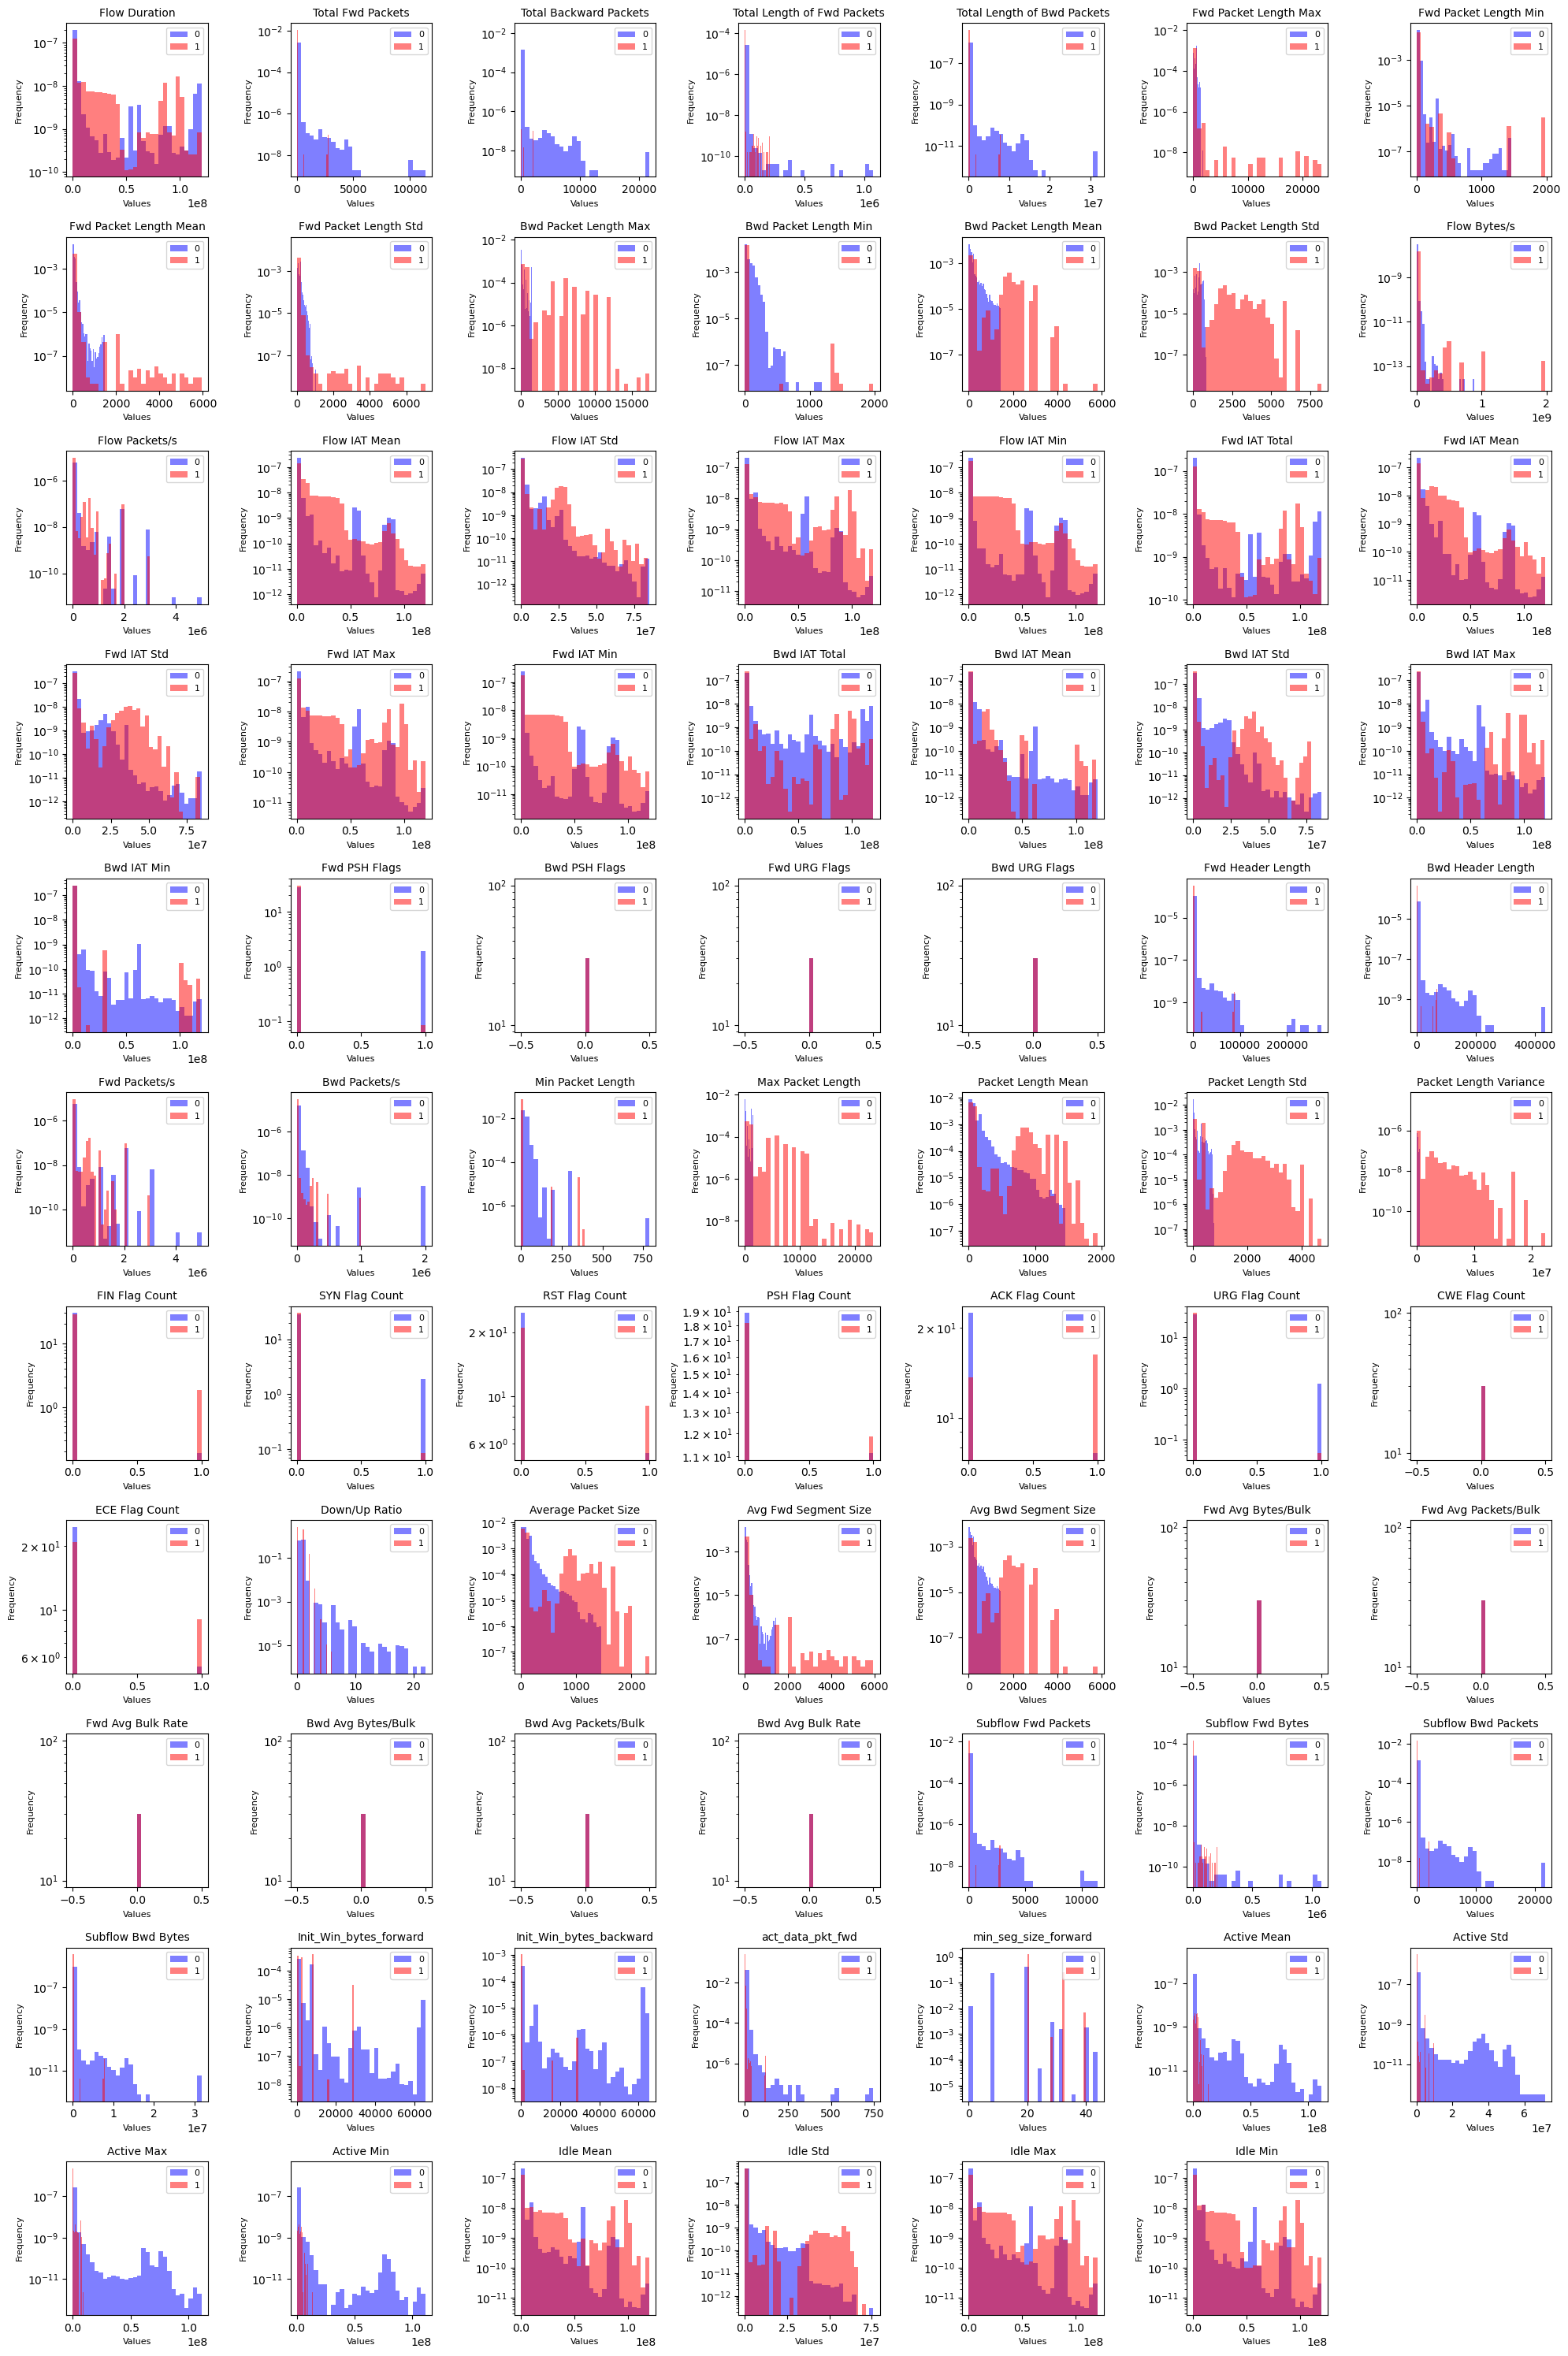

In [54]:
# Convert to dtypes
merged_df['Label'] = merged_df['Label'].astype('category')
merged_df['Destination Port'] = merged_df['Destination Port'].astype('category')
merged_df['Source Port'] = merged_df['Source Port'].astype('category')
merged_df['Protocol'] = merged_df['Protocol'].astype('category')
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'], errors='coerce')
numerical_cols = merged_df.select_dtypes(include=['number']).columns
# print(len(numerical_cols))

# Define color mapping
label_colors = {0: 'blue', 1: 'red'}

# Set figure size
plt.figure(figsize=(20, 30))  # Adjusted for better spacing

# Loop through each numerical column and plot its histogram
rows, cols = 11, 7 # 11 rows × 7 columns = 77 plots
for i, column in enumerate(numerical_cols):  
    plt.subplot(rows, cols, i + 1)  

    for label, color in label_colors.items():
        subset = merged_df[merged_df['Label'] == label][column]
        
        # Remove NaN and infinite values
        subset = subset.replace([np.inf, -np.inf], np.nan).dropna()

        if not subset.empty:
            plt.hist(subset, bins=30, label=label, alpha=0.5, color=color, density=True)
    
    plt.title(column, fontsize=10)
    plt.xlabel('Values', fontsize=8)
    plt.ylabel('Frequency', fontsize=8)
    plt.yscale("log")  # Log scale for better separation
    plt.legend(fontsize=8)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

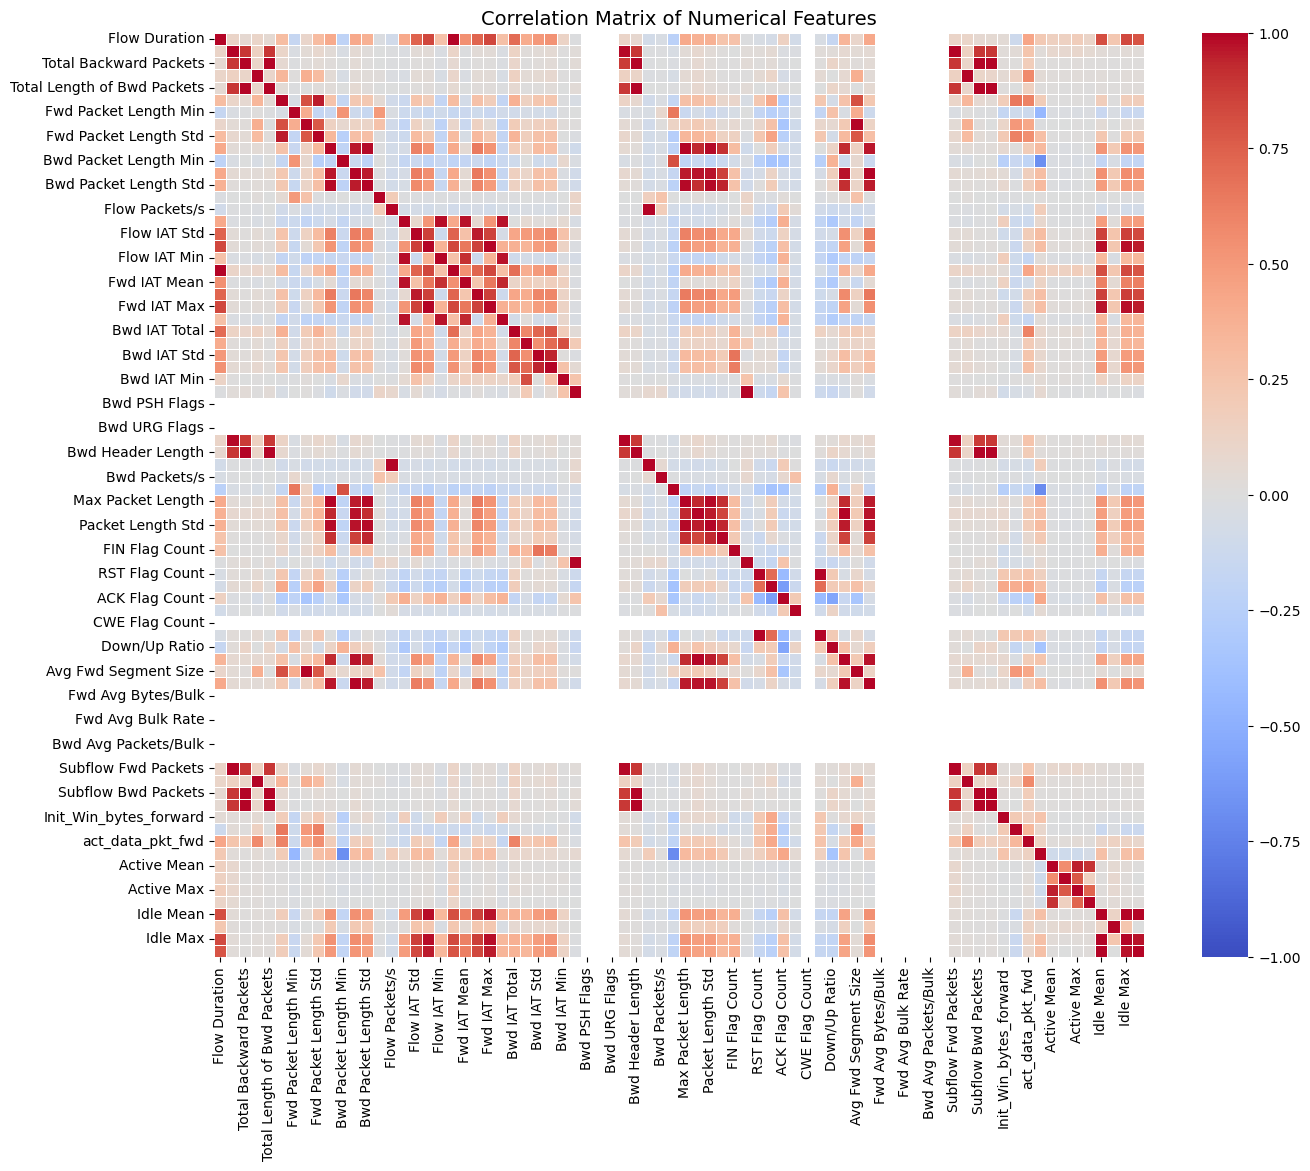

In [26]:
# Compute correlation matrix
corr_matrix = merged_df[numerical_cols].corr()

# Set figure size
plt.figure(figsize=(15, 12))

# Create heatmap
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)

# Title
plt.title("Correlation Matrix of Numerical Features", fontsize=14)

# Show plot
plt.show()

### Remove uninformative features and features with high correlation

In [55]:
uninformative_features = [
    'Bwd Avg Bulk Rate', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',  
    'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Fwd Avg Bytes/Bulk',  
    'CWE Flag Count', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Timestamp','Source Port'
]
merged_df.drop(columns=uninformative_features, inplace=True, errors='ignore')

high_correlation = [
    'Fwd Header Length', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 
    'act_data_pkt_fwd', 'Total Length of Bwd Packets', 'Bwd Header Length', 'Subflow Bwd Packets', 
    'Subflow Bwd Bytes', 'Fwd Packets/s', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Min',
    'Idle Min', 'Idle Max', 'Min Packet Length', 'Fwd Seg Size Min', 'Fwd Packet Length Std',
    'Fwd IAT Total', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Avg Fwd Segment Size', 
    'Idle Mean', 'Average Packet Size', 'Avg Bwd Segment Size', 'Active Max', 'Active Min', 
    'Fwd IAT Max', 'SYN Flag Count', 'ECE Flag Count','FIN Flag Count', 'Fwd PSH Flags', 'Active Std', 'Bwd Packet Length Max'
]

merged_df.drop(columns=high_correlation , inplace=True, errors='ignore')

In [56]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2301349 entries, 0 to 2301348
Data columns (total 39 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   Flow ID                      object  
 1   Source IP                    object  
 2   Destination IP               object  
 3   Destination Port             category
 4   Protocol                     category
 5   Flow Duration                int64   
 6   Total Fwd Packets            int64   
 7   Total Backward Packets       int64   
 8   Total Length of Fwd Packets  float64 
 9   Fwd Packet Length Max        float64 
 10  Fwd Packet Length Min        float64 
 11  Fwd Packet Length Mean       float64 
 12  Bwd Packet Length Min        float64 
 13  Bwd Packet Length Mean       float64 
 14  Bwd Packet Length Std        float64 
 15  Flow Bytes/s                 float64 
 16  Flow Packets/s               float64 
 17  Flow IAT Mean                float64 
 18  Flow IAT Std          

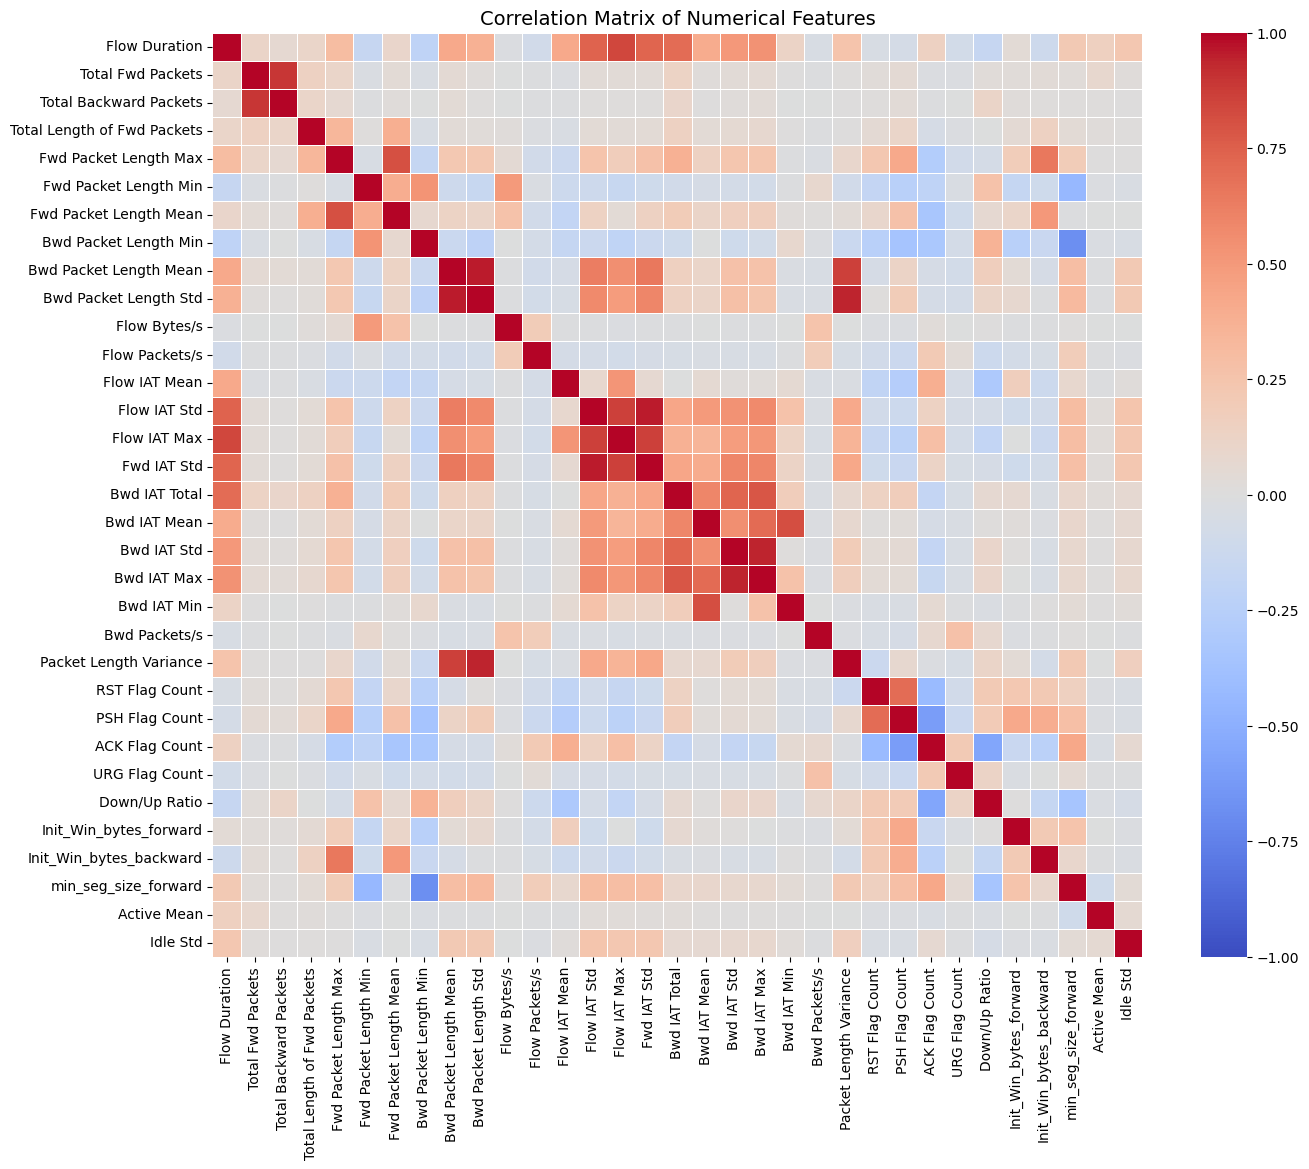

In [40]:
# Compute correlation matrix
numerical_cols = merged_df.select_dtypes(include=['number']).columns
corr_matrix = merged_df[numerical_cols].corr()

# Set figure size
plt.figure(figsize=(15, 12))

# Create heatmap
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)

# Title
plt.title("Correlation Matrix of Numerical Features", fontsize=14)

# Show plot
plt.show()

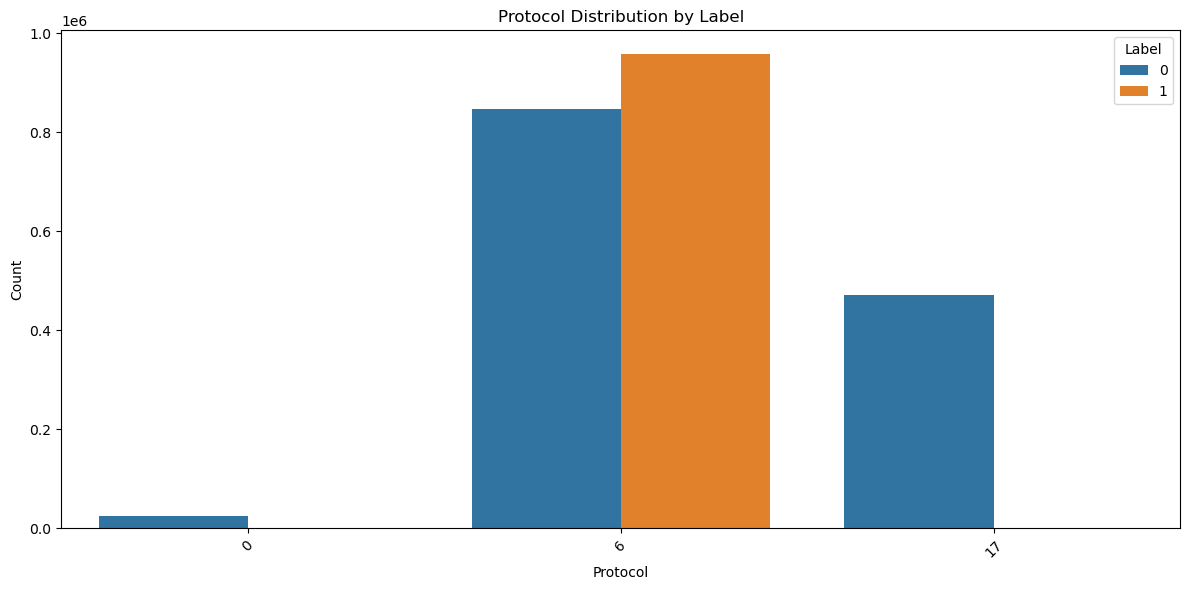

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot for 'Protocol'
plt.figure(figsize=(12, 6))
sns.countplot(data=merged_df, x='Protocol', hue='Label')
plt.title("Protocol Distribution by Label")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.fillna(0, inplace=True) 
merged_df["Flow Bytes/s"].fillna(0, inplace=True)
nan_counts = merged_df.isna().sum()

/var/folders/kf/13qk055j6hz1vpgtkkpw6pyw0000gn/T/ipykernel_86483/4217518596.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["Flow Bytes/s"].fillna(0, inplace=True)


### Encode port and protocol

In [58]:
protocol_ohe = pd.get_dummies(merged_df['Protocol'], prefix='Protocol')
merged_df = pd.concat([merged_df, protocol_ohe], axis=1)

In [ ]:
# Drop unique identifier columns from the dataframe
merged_df = merged_df.drop(columns=['Flow ID', 'Source IP', 'Destination IP', 'Destination Port', 'Protocol'])
merged_df = merged_df.drop(columns=['Protocol'])

# Baseline Models

In [ ]:
# Random Forest Prediction - Baseline Model
df_model = merged_df.copy()

# Separate the target variable (Label) and the features
X = df_model.drop(columns=['Label'])  # Drop the target variable from the features
y = df_model['Label']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

In [72]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, X, y, cv=5, scoring='roc_auc')
print("CV AUC scores:", scores)
print("Mean AUC:", scores.mean())

IOStream.flush timed out


CV AUC scores: [0.99997827 0.9999755  0.99999466 0.99558282 0.9975113 ]
Mean AUC: 0.9986085103719979


In [67]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print accuracy score
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Optional: Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Additional metrics
precision = precision_score(y_test, y_pred, average='macro')  # or 'micro', 'weighted' as needed
recall = recall_score(y_test, y_pred, average='macro')  # or 'micro', 'weighted' as needed
f1 = f1_score(y_test, y_pred, average='macro')  # or 'micro', 'weighted' as needed

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    268658
           1       1.00      1.00      1.00    191612

    accuracy                           1.00    460270
   macro avg       1.00      1.00      1.00    460270
weighted avg       1.00      1.00      1.00    460270

Accuracy Score: 0.9999283029526148
Confusion Matrix:
[[268632     26]
 [     7 191605]]
Precision: 0.9999191326522002
Recall: 0.9999333452629326
F1 Score: 0.9999262371035338


Feature Importances (sorted from high to low):
Flow IAT Max: 0.12559534453092483
Fwd Packet Length Mean: 0.07658540811803392
Flow Packets/s: 0.0631379823636458
Fwd Packet Length Max: 0.06304314337163604
min_seg_size_forward: 0.060129897115670856
Flow IAT Mean: 0.05918328230469306
Total Length of Fwd Packets: 0.058225255435893145
Bwd Packet Length Std: 0.05793016867259651
Flow Duration: 0.05506924655359838
Init_Win_bytes_forward: 0.05054705167536367
Packet Length Variance: 0.043895375843425954
Bwd Packet Length Mean: 0.04365488477288011
Init_Win_bytes_backward: 0.037273190927296855
Bwd IAT Min: 0.023212529584685858
Total Fwd Packets: 0.022555173435174106
Total Backward Packets: 0.018202535679701315
Fwd IAT Std: 0.01795826615359662
Flow IAT Std: 0.017768320763798546
Bwd Packets/s: 0.01763266915377961
Bwd IAT Total: 0.014976043134762515
Active Mean: 0.012720444515761953
ACK Flag Count: 0.007937667022377939
Bwd IAT Max: 0.007434623169780187
Bwd Packet Length Min: 0.006803727970174498
Flow 

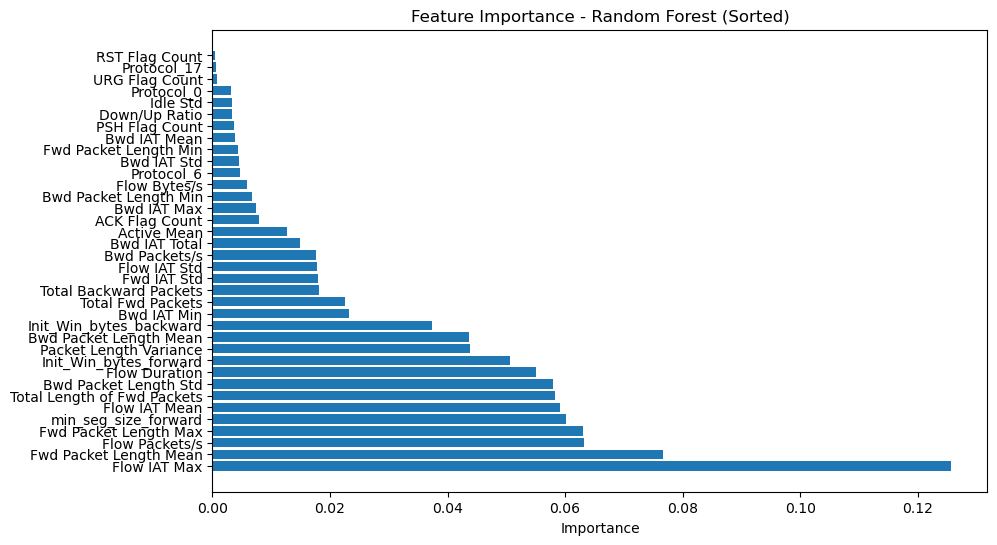

In [68]:
# Get feature importances from the RandomForest model
feature_importances = rf_model.feature_importances_

# Create a list of feature names and their corresponding importances
feature_importance_dict = zip(X.columns, feature_importances)  # Use X.columns to keep the column names intact

# Sort the features by importance (high to low)
sorted_features = sorted(feature_importance_dict, key=lambda x: x[1], reverse=True)

# Display sorted feature importances
print("Feature Importances (sorted from high to low):")
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

# Separate the sorted features and importances for plotting
sorted_feature_names = [x[0] for x in sorted_features]
sorted_importances = [x[1] for x in sorted_features]

# Plot the sorted feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest (Sorted)')
plt.show()

Random Forest ROC AUC Score: 0.999990596544335


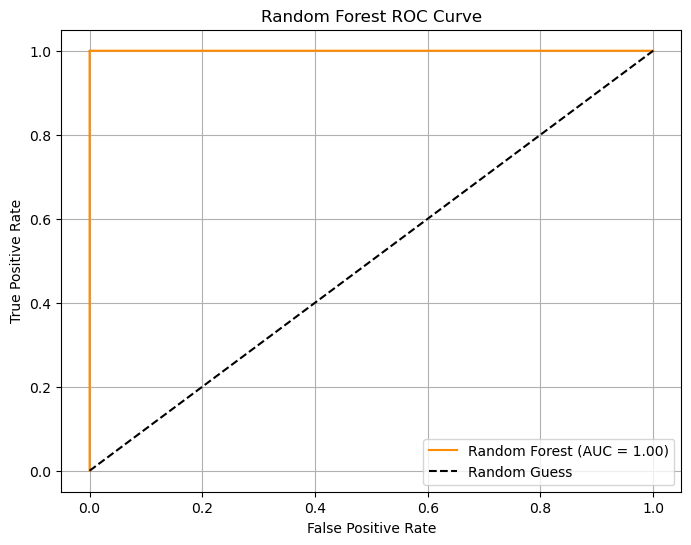

In [71]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class (usually class 1)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Compute AUC-ROC score
auc_score_rf = roc_auc_score(y_test, y_proba_rf)
print("Random Forest ROC AUC Score:", auc_score_rf)

# Plot ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_score_rf:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("Random Forest ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

In [69]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97    268658
           1       0.97      0.95      0.96    191612

    accuracy                           0.97    460270
   macro avg       0.97      0.97      0.97    460270
weighted avg       0.97      0.97      0.97    460270

Confusion Matrix:
[[263260   5398]
 [  8991 182621]]


ROC AUC Score: 0.9922591896636506


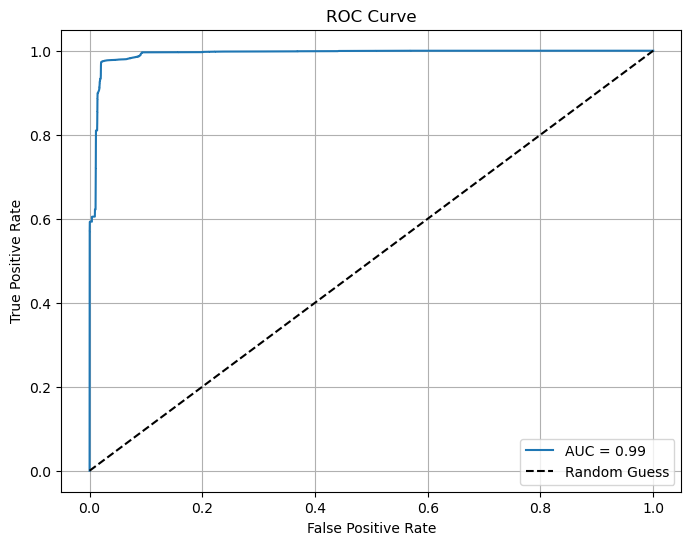

In [70]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class (usually class 1)
y_proba = logreg_model.predict_proba(X_test)[:, 1]

# Compute AUC-ROC score
auc_score = roc_auc_score(y_test, y_proba)
print("ROC AUC Score:", auc_score)

# Plot ROC Curve (optional)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()
